# Neuron Segmentation Results Visualization

This notebook creates visualization plots comparing CREMI scores between CM-GLLF and SOTA methods for neuron segmentation analysis.

## 1. Import Required Libraries

Import necessary libraries including matplotlib, numpy, json, os, and seaborn for data visualization and analysis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import math
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from matplotlib.patches import Rectangle

# Set matplotlib backend and style
plt.style.use('default')
%matplotlib inline

# Set figure parameters for high quality plots
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Process Results Data

Load the best segmentation results from JSON files and extract CREMI scores for all parameter combinations.

In [2]:
# Load best results from JSON file
def load_best_results():
    """Load the best segmentation results"""
    with open('best_segmentation_results_B.json', 'r') as f:
        best_results = json.load(f)
    return best_results

def calculate_cremi_score(file_path):
    """Calculate CREMI score from evaluation JSON file"""
    try:
        with open(file_path, 'r') as f:
            js = json.load(f)
        
        # Calculate CREMI metrics
        rand_split = js['rand_split']
        rand_merge = js['rand_merge']
        voi_split = js['voi_split']
        voi_merge = js['voi_merge']
        
        arand = 1.0 - 2 * rand_split * rand_merge / (rand_split + rand_merge)
        cremi_score = math.sqrt(arand * (voi_split + voi_merge))
        
        return cremi_score
    except (FileNotFoundError, KeyError, json.JSONDecodeError) as e:
        return float('inf')  # Return high score for failed cases

def collect_all_cremi_scores():
    """Collect CREMI scores for all mu and I combinations"""
    sample_name = 'B'
    seg_path = f'./segs/{sample_name}/whole'
    
    # Parameters from main.py
    thresholds = list(np.around(np.arange(0.1, 1, 0.1), decimals=1))
    merfs = ('median_aff_histograms', '85_aff_histograms', 'median_aff', '85_aff')
    Mus = list(np.around(np.arange(0.1, 1, 0.1), decimals=1))
    Is = list(np.around(np.arange(0.1, 1, 0.1), decimals=1))
    
    results_matrix = {}
    
    for mu in Mus:
        for inflec in Is:
            folder_name = f'mu_{mu}_I_{inflec}'
            folder_path = os.path.join(seg_path, folder_name)
            
            best_score = float('inf')
            if os.path.exists(folder_path):
                for mf in merfs:
                    for th in thresholds:
                        json_file = os.path.join(folder_path, f'{mf}th_0.{th:.6f}.json')
                        if os.path.exists(json_file):
                            score = calculate_cremi_score(json_file)
                            best_score = min(best_score, score)
            
            if (mu, inflec) not in results_matrix:
                results_matrix[(mu, inflec)] = best_score
    
    return results_matrix, Mus, Is

# Load data
best_results = load_best_results()
all_scores, Mus, Is = collect_all_cremi_scores()

print("Data loaded successfully!")
print(f"Best SOTA score: {best_results['sota']['score']:.6f}")
print(f"Best CM-GLLF score: {best_results['cmgllf']['score']:.6f}")
print(f"Best CM-GLLF parameters: μ={best_results['cmgllf']['params']['mu']}, I={best_results['cmgllf']['params']['I']}")
print(f"Collected scores for {len(all_scores)} parameter combinations")

Data loaded successfully!
Best SOTA score: 0.166493
Best CM-GLLF score: 0.151496
Best CM-GLLF parameters: μ=0.4, I=0.3
Collected scores for 81 parameter combinations


## 3. Create Bar Plot Comparing Best CM-GLLF vs SOTA

Generate a bar plot comparing the best CREMI scores with custom labels and relative improvement.

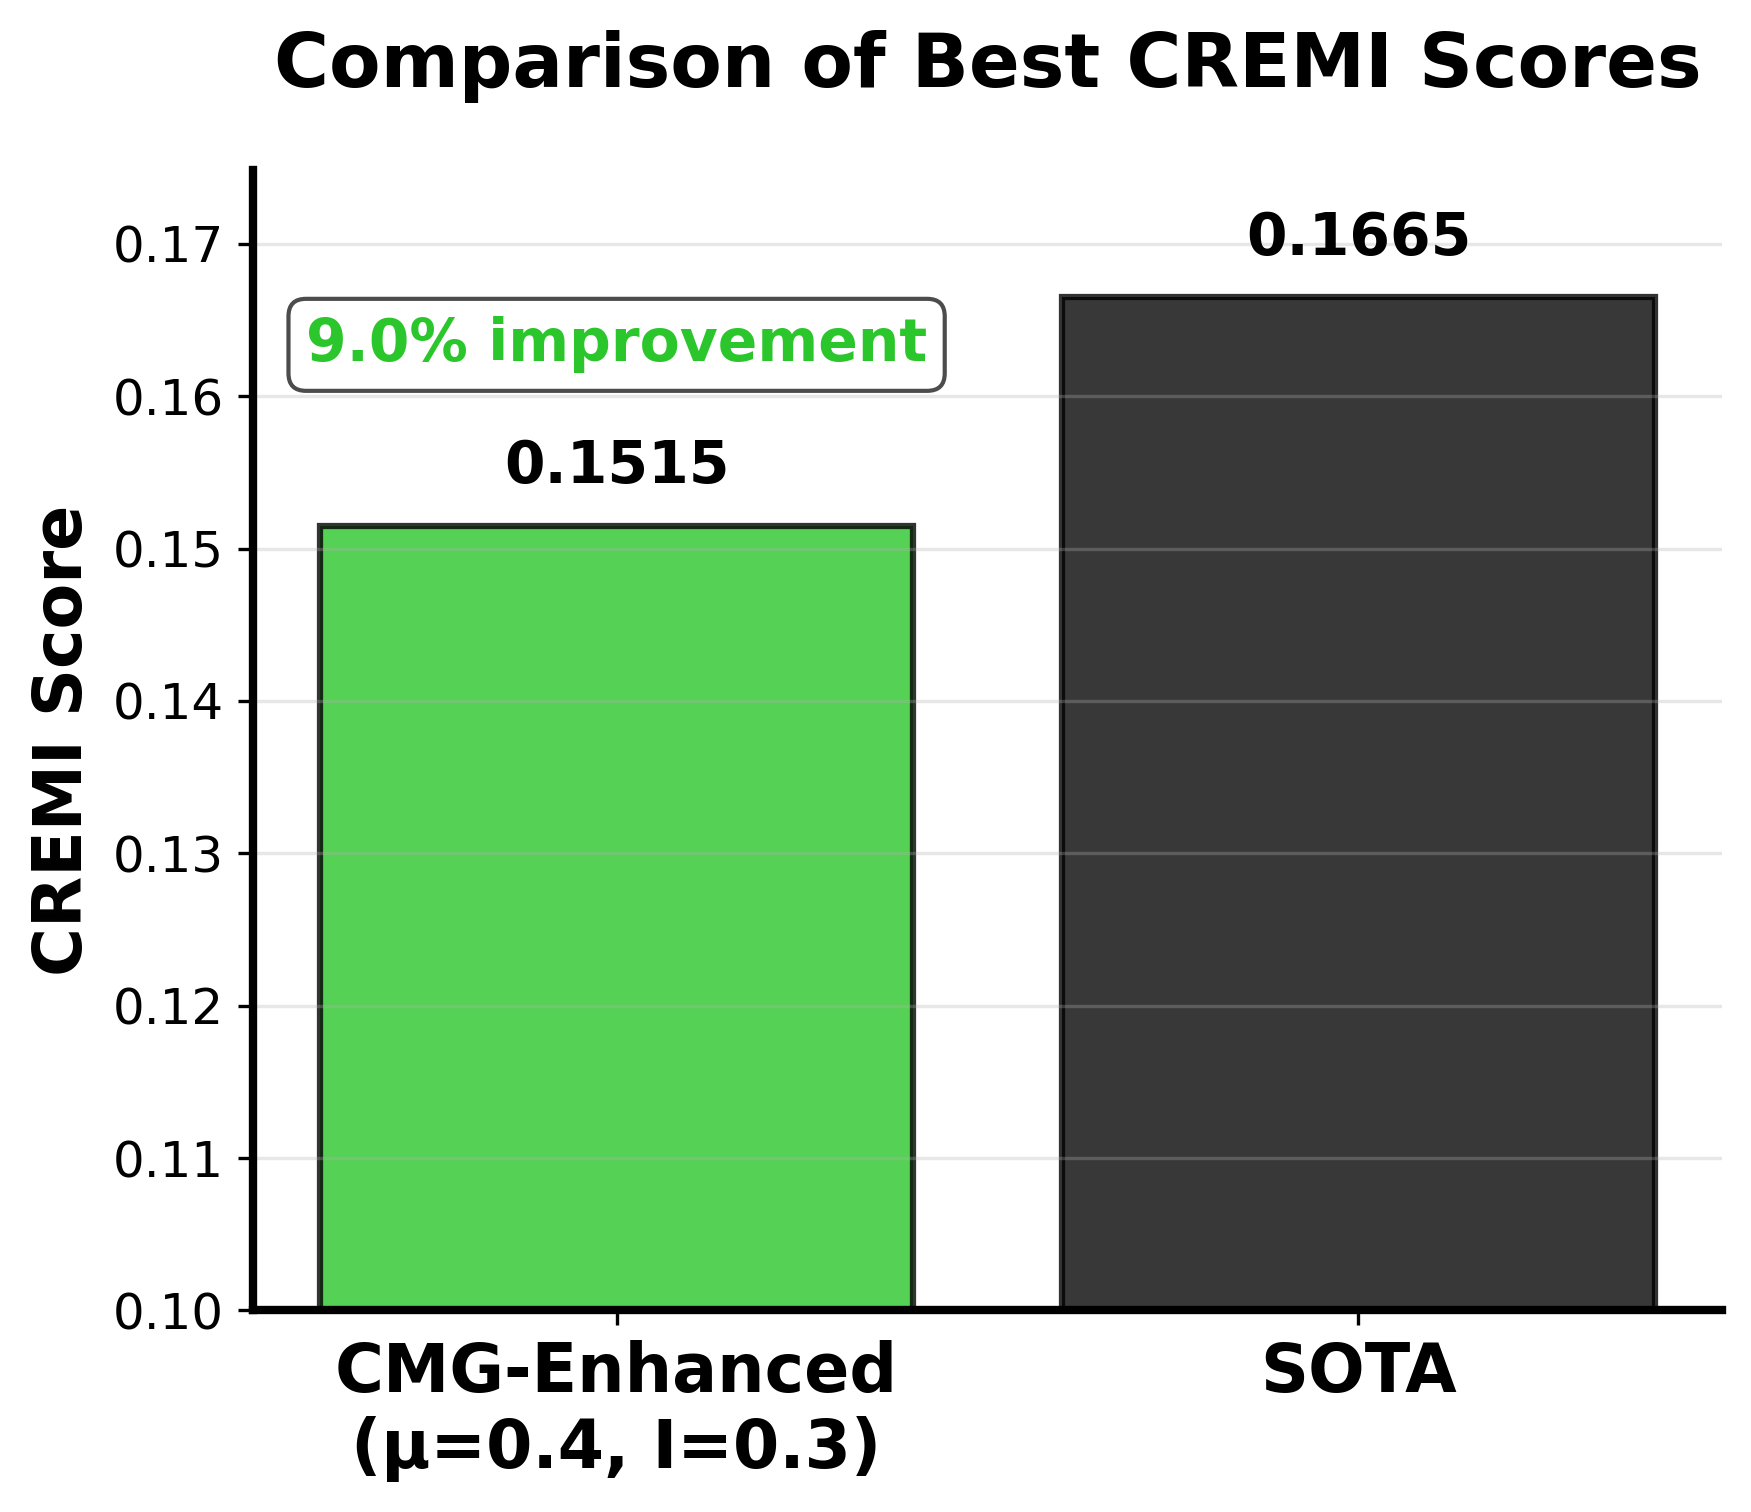

SOTA score: 0.166493
CM-GLLF score: 0.151496
Relative improvement: 9.01%


In [3]:
# Create bar plot comparing CM-GLLF vs SOTA
def create_comparison_bar_plot():
    fig, ax = plt.subplots(figsize=(6, 5.2))
    
    # Extract scores
    sota_score = best_results['sota']['score']
    cmgllf_score = best_results['cmgllf']['score']
    
    # Calculate relative improvement
    relative_improvement = (sota_score - cmgllf_score) / sota_score * 100
    
    # Create labels
    cmgllf_params = best_results['cmgllf']['params']
    labels = [f'CMG-Enhanced\n(μ={cmgllf_params["mu"]}, I={cmgllf_params["I"]})', 'SOTA']
    scores = [cmgllf_score, sota_score]

    # Create bars with consistent colors: Green for CMG, Black for SOTA
    colors = ["#2bc62b", "#060606"]  # Green for CMG, Black for SOTA
    bars = ax.bar(labels, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on top of bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=14)
    
    # Add relative improvement annotation on CMG bar - use green color to match CMG
    ax.text(bars[0].get_x() + bars[0].get_width()/2., 
            bars[0].get_height() + 0.01,  # Increased from 0.008 to 0.015
            f'{relative_improvement:.1f}% improvement', 
            ha='center', va='bottom', fontweight='bold', 
            fontsize=14, color='#2bc62b',  # Green to match CMG
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
    
    # Customize plot
    ax.set_ylabel('CREMI Score', fontsize=16, fontweight='bold')
    ax.set_title('Comparison of Best CREMI Scores', fontsize=18, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(bottom=0.1)  # Increased from 1.15 to 1.2 to accommodate higher text
    
    # Set larger font size for x-axis tick labels
    ax.tick_params(axis='x', labelsize=16)
    # Set x-tick labels to bold using a different approach
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    
    # Improve aesthetics
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('cremi_comparison_bar_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"SOTA score: {sota_score:.6f}")
    print(f"CM-GLLF score: {cmgllf_score:.6f}")
    print(f"Relative improvement: {relative_improvement:.2f}%")

create_comparison_bar_plot()

## 3.1. Detailed Comparison: Rand Split and Rand Merge Metrics

Create a detailed comparison of rand_split and rand_merge metrics between CM-GLLF and SOTA methods.

Loading CM-GLLF metrics from: ./segs/B/whole/mu_0.4_I_0.3/median_aff_histogramsth_0.0.900000.json
Loading SOTA metrics from: ./segs/B/whole/sota/median_affth_0.0.800000.json


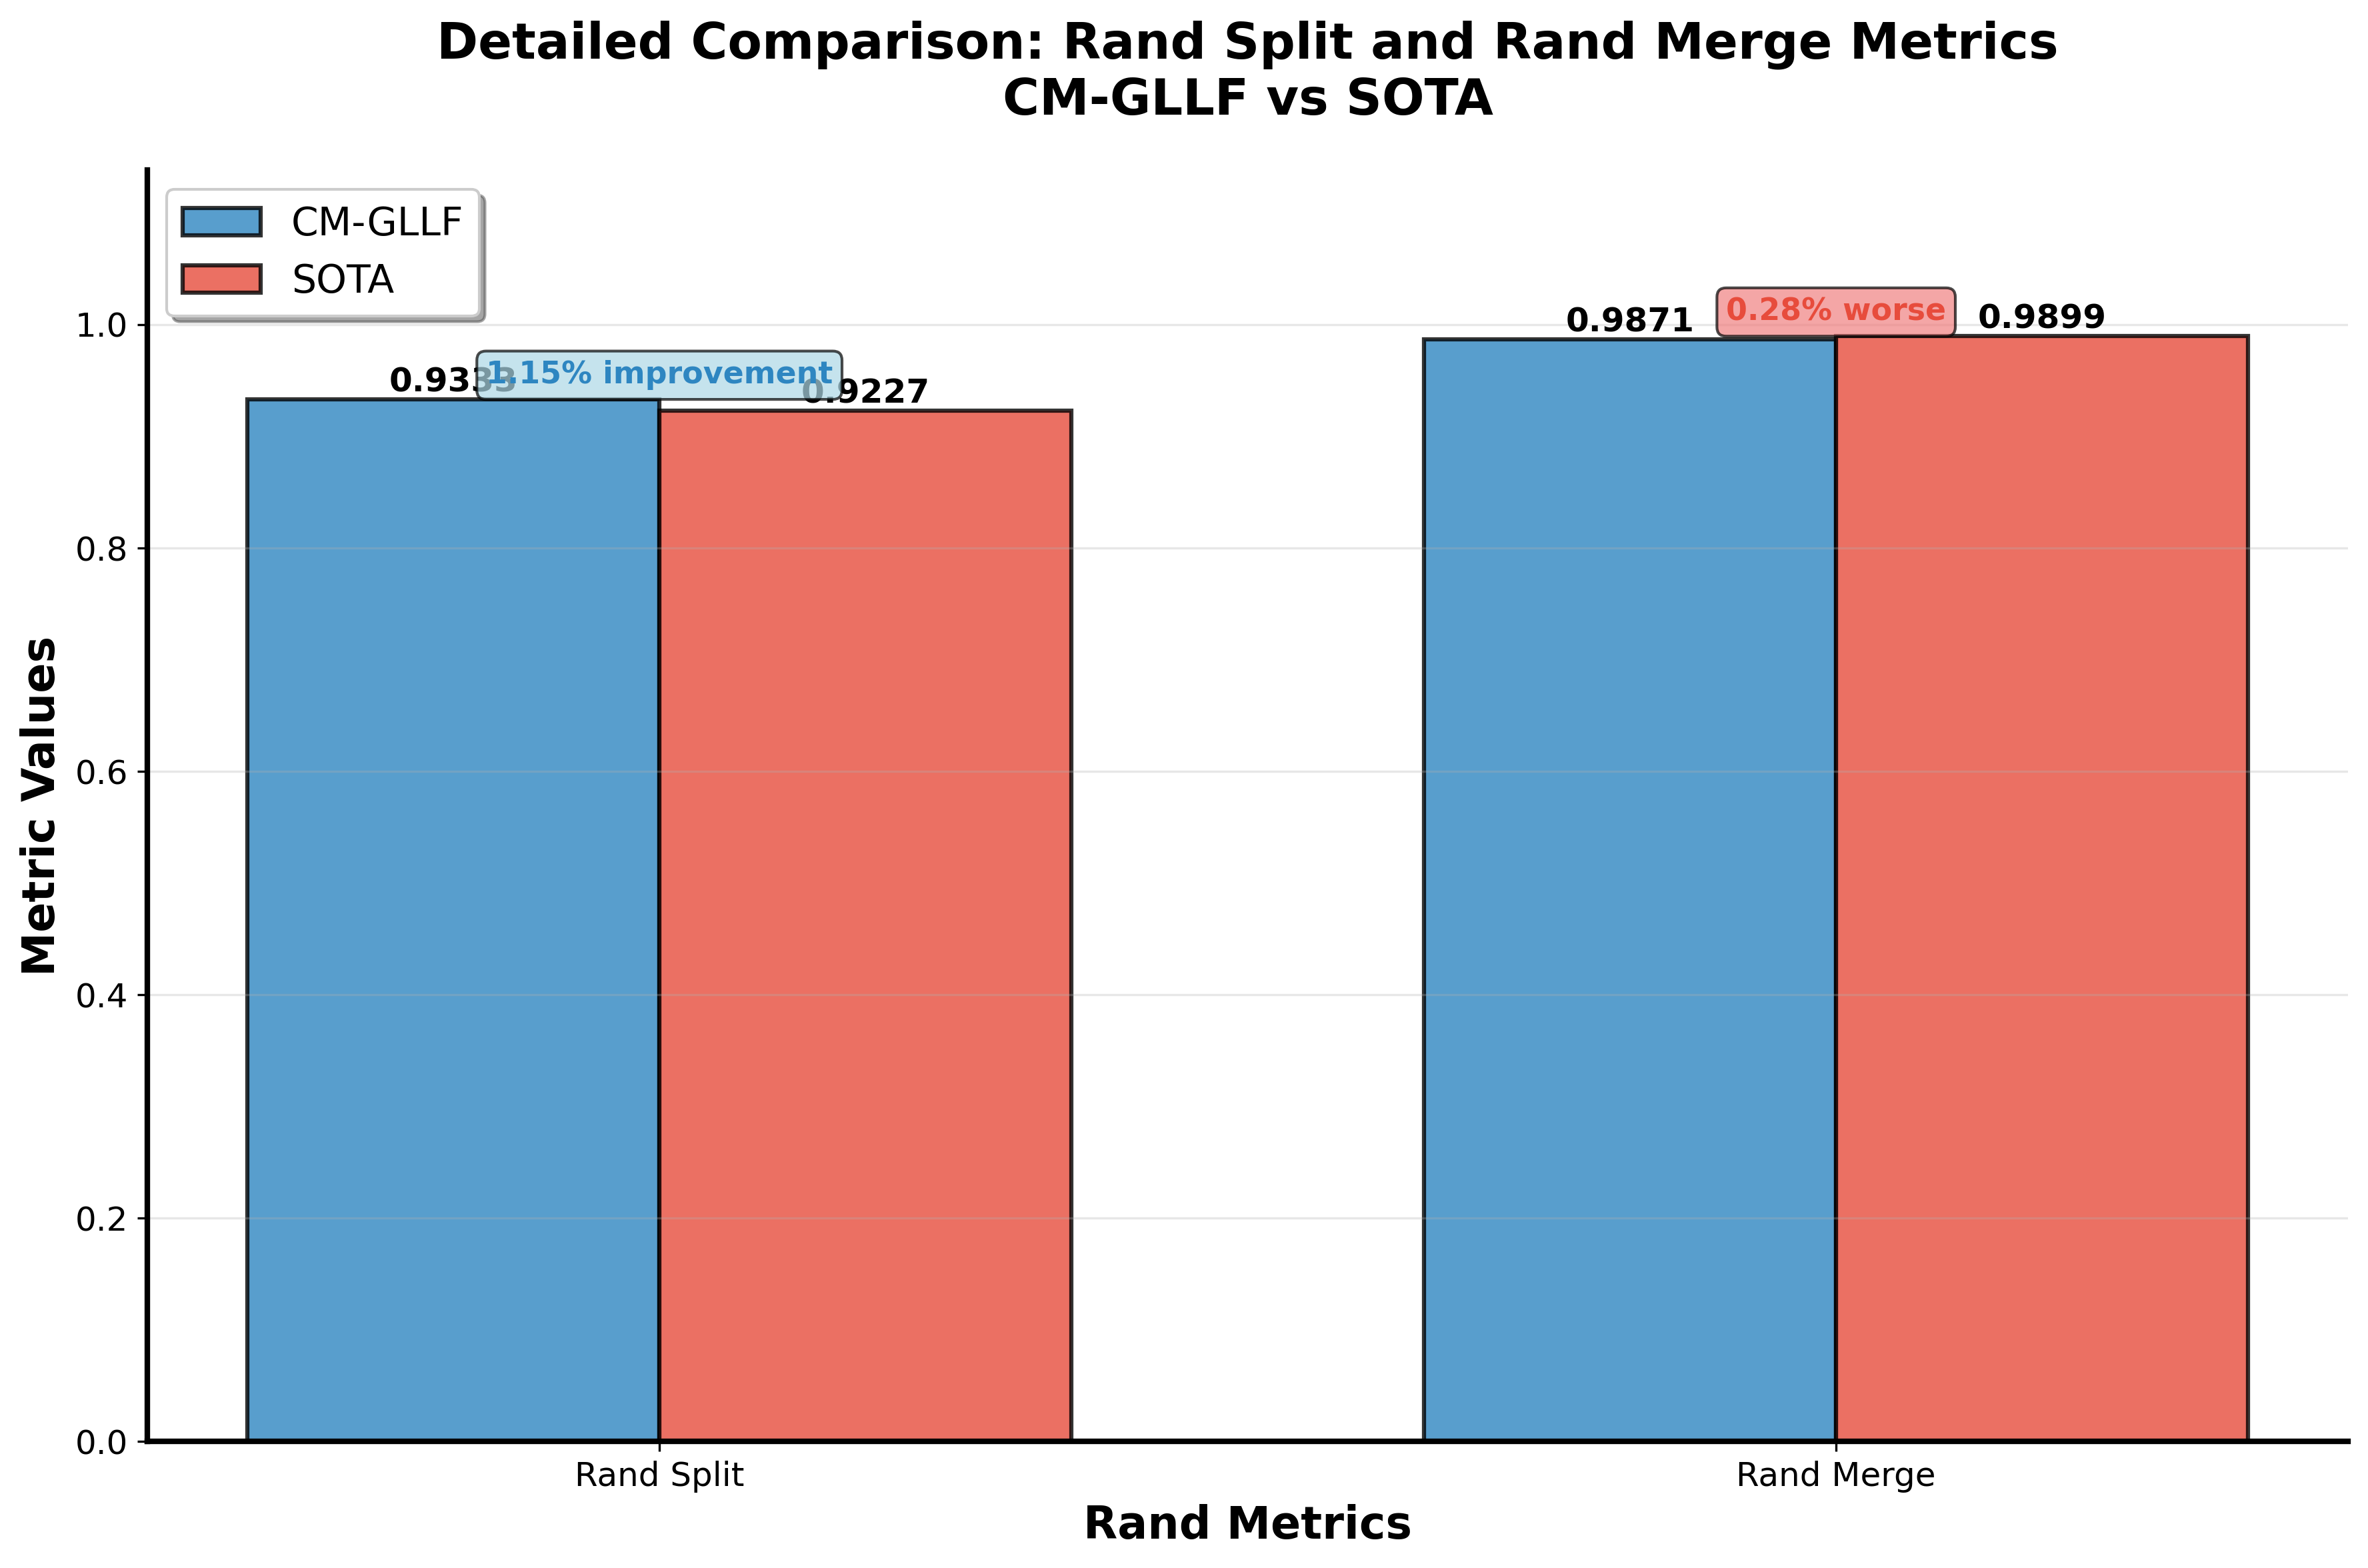


DETAILED RAND METRICS COMPARISON
Metric          CM-GLLF      SOTA         Improvement 
------------------------------------------------------------
Rand Split      0.933293     0.922704     1.15        %
Rand Merge      0.987055     0.989870     -0.28       %
Note: Higher values are better for both Rand Split and Rand Merge metrics


In [4]:
# Create detailed comparison of rand_split and rand_merge metrics
def load_detailed_metrics():
    """Load detailed rand_split and rand_merge metrics for best configurations"""
    
    # CM-GLLF best configuration
    cmgllf_params = best_results['cmgllf']['params']
    cmgllf_file = f"./segs/B/whole/mu_{cmgllf_params['mu']}_I_{cmgllf_params['I']}/{cmgllf_params['merge_function']}th_0.{cmgllf_params['threshold']:.6f}.json"
    
    # SOTA best configuration  
    sota_params = best_results['sota']['params']
    sota_file = f"./segs/B/whole/sota/{sota_params['merge_function']}th_0.{sota_params['threshold']:.6f}.json"
    
    print(f"Loading CM-GLLF metrics from: {cmgllf_file}")
    print(f"Loading SOTA metrics from: {sota_file}")
    
    # Load metrics
    with open(cmgllf_file, 'r') as f:
        cmgllf_metrics = json.load(f)
    
    with open(sota_file, 'r') as f:
        sota_metrics = json.load(f)
    
    return cmgllf_metrics, sota_metrics

def create_rand_metrics_comparison():
    """Create bar plot comparing rand_split and rand_merge metrics"""
    
    # Load detailed metrics
    cmgllf_metrics, sota_metrics = load_detailed_metrics()
    
    # Extract rand metrics
    metrics = ['Rand Split', 'Rand Merge']
    cmgllf_values = [cmgllf_metrics['rand_split'], cmgllf_metrics['rand_merge']]
    sota_values = [sota_metrics['rand_split'], sota_metrics['rand_merge']]
    
    # Create subplot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set up bar positions
    x = np.arange(len(metrics))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x - width/2, cmgllf_values, width, label='CM-GLLF', 
                   color='#2E86C1', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, sota_values, width, label='SOTA', 
                   color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on top of bars
    def add_value_labels(bars, values):
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{value:.4f}', ha='center', va='bottom', 
                    fontweight='bold', fontsize=12)
    
    add_value_labels(bars1, cmgllf_values)
    add_value_labels(bars2, sota_values)
    
    # Calculate improvements for each metric
    rand_split_improvement = (cmgllf_values[0] - sota_values[0]) / sota_values[0] * 100
    rand_merge_improvement = (cmgllf_values[1] - sota_values[1]) / sota_values[1] * 100
    
    # Add improvement annotations
    for i, (improvement, metric) in enumerate(zip([rand_split_improvement, rand_merge_improvement], metrics)):
        if improvement > 0:  # CM-GLLF is better (higher is better for rand metrics)
            ax.text(x[i], max(cmgllf_values[i], sota_values[i]) + 0.008,
                    f'{improvement:.2f}% improvement', 
                    ha='center', va='bottom', fontweight='bold', 
                    fontsize=11, color='#2E86C1',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
        else:  # SOTA is better
            ax.text(x[i], max(cmgllf_values[i], sota_values[i]) + 0.008,
                    f'{abs(improvement):.2f}% worse', 
                    ha='center', va='bottom', fontweight='bold', 
                    fontsize=11, color='#E74C3C',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.7))
    
    # Customize plot
    ax.set_xlabel('Rand Metrics', fontsize=16, fontweight='bold')
    ax.set_ylabel('Metric Values', fontsize=16, fontweight='bold')
    ax.set_title('Detailed Comparison: Rand Split and Rand Merge Metrics\nCM-GLLF vs SOTA', 
                 fontsize=18, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Set y-axis limits with padding for annotations
    y_max = max(max(cmgllf_values), max(sota_values))
    ax.set_ylim(0, y_max * 1.15)
    
    # Improve aesthetics
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('rand_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed comparison
    print("\n" + "="*60)
    print("DETAILED RAND METRICS COMPARISON")
    print("="*60)
    print(f"{'Metric':<15} {'CM-GLLF':<12} {'SOTA':<12} {'Improvement':<12}")
    print("-" * 60)
    print(f"{'Rand Split':<15} {cmgllf_values[0]:<12.6f} {sota_values[0]:<12.6f} {rand_split_improvement:<12.2f}%")
    print(f"{'Rand Merge':<15} {cmgllf_values[1]:<12.6f} {sota_values[1]:<12.6f} {rand_merge_improvement:<12.2f}%")
    print("="*60)
    print("Note: Higher values are better for both Rand Split and Rand Merge metrics")

# Create the comparison plot
create_rand_metrics_comparison()

## 4. Prepare Data for Line Plot

Organize CREMI score data by mu and I values for the line plot visualization.

In [5]:
# Prepare data for line plot
def prepare_line_plot_data():
    """Organize data for line plot: mu values vs CREMI scores for different I values"""
    
    # Organize data by I values
    line_data = {}
    for I_val in Is:
        mu_scores = []
        for mu_val in Mus:
            score = all_scores.get((mu_val, I_val), float('inf'))
            mu_scores.append(score)
        line_data[I_val] = mu_scores
    
    return line_data

# Prepare the data
line_data = prepare_line_plot_data()

# Filter out any infinite values for visualization
filtered_line_data = {}
for I_val, scores in line_data.items():
    filtered_scores = [score if score != float('inf') else np.nan for score in scores]
    if not all(np.isnan(filtered_scores)):  # Only include lines with valid data
        filtered_line_data[I_val] = filtered_scores

print(f"Prepared line plot data for {len(filtered_line_data)} I values")
print(f"Mu values: {Mus}")
print(f"I values with valid data: {sorted(filtered_line_data.keys())}")

# Check data range for plotting
all_valid_scores = [score for scores in filtered_line_data.values() for score in scores if not np.isnan(score)]
print(f"CREMI score range: {min(all_valid_scores):.4f} to {max(all_valid_scores):.4f}")

Prepared line plot data for 9 I values
Mu values: [np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9)]
I values with valid data: [np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9)]
CREMI score range: 0.1515 to 0.4355


## 5. Create Line Plot with Mu vs CREMI Score

Generate a line plot with mu values on x-axis and CREMI scores on y-axis, with different lines for I values using jet colormap.

C:\Users\Wenqi\AppData\Local\Temp\ipykernel_34868\783548257.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')
C:\Users\Wenqi\AppData\Local\Temp\ipykernel_34868\783548257.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


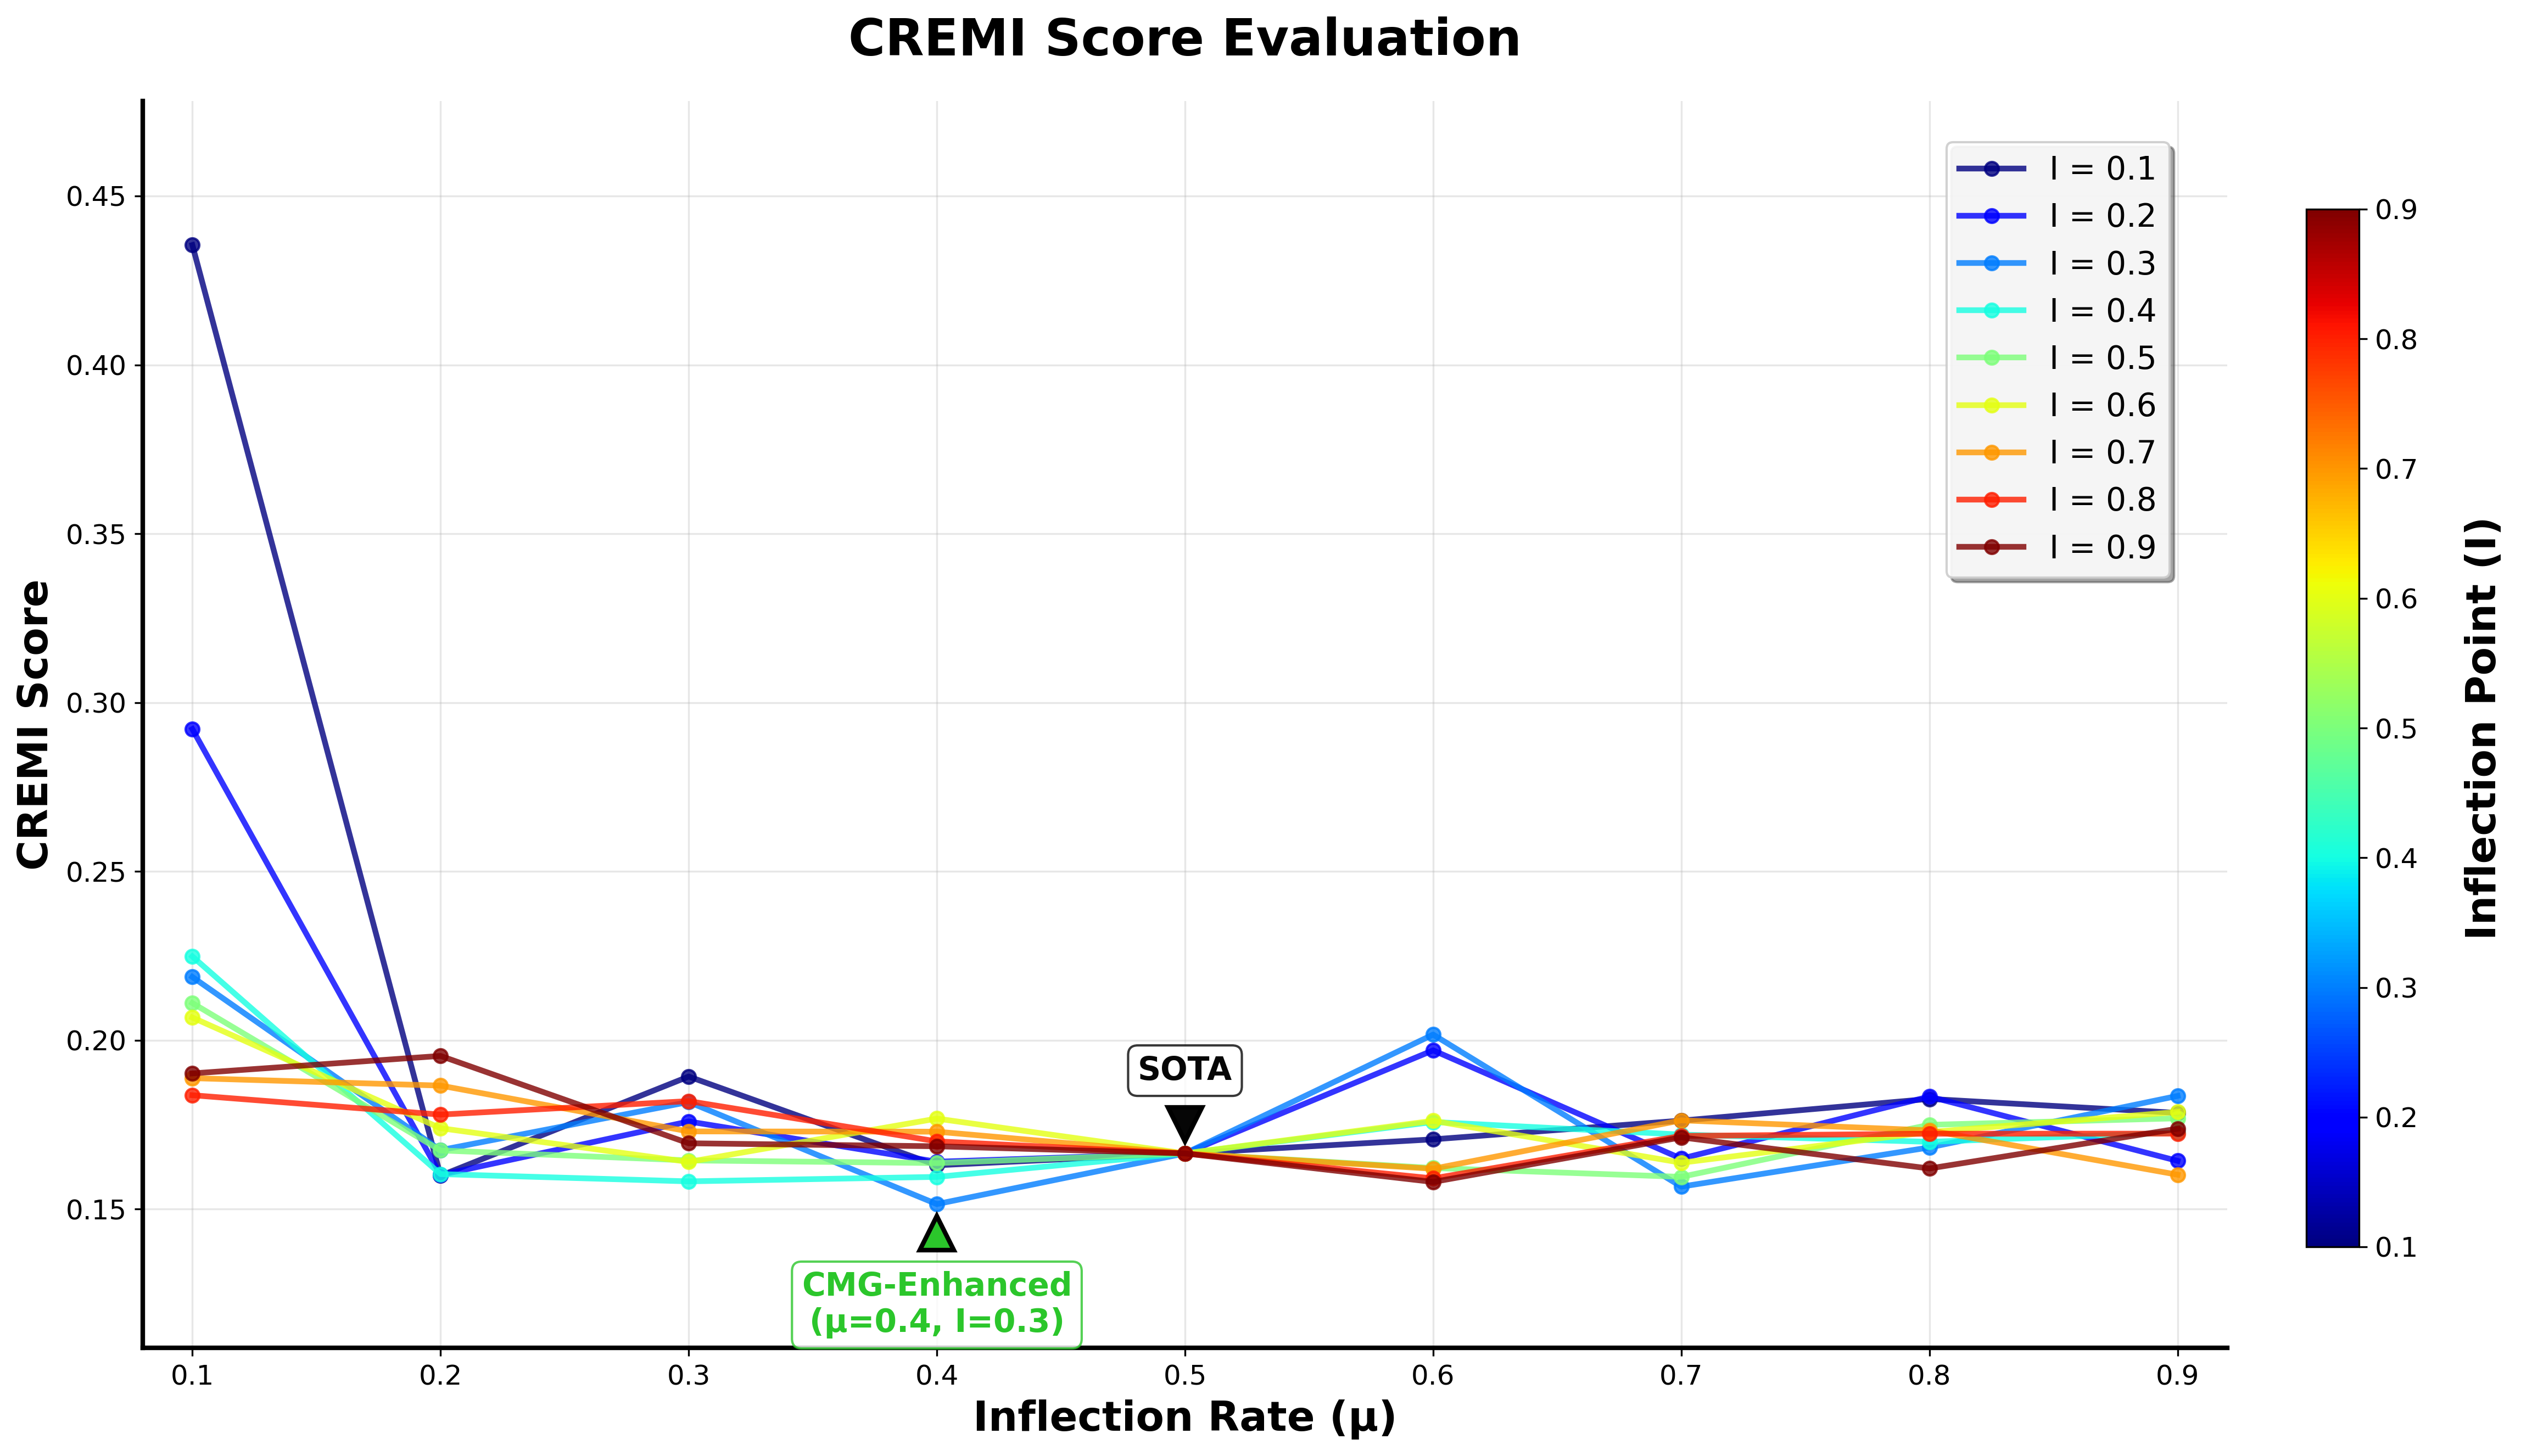

In [6]:
# Create line plot with colormap
def create_line_plot_with_colormap():
    # Create figure with space for colorbar
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # Set up jet colormap
    cmap = cm.get_cmap('jet')
    I_values_sorted = sorted(filtered_line_data.keys())
    n_lines = len(I_values_sorted)
    
    # Normalize I values for colormap (0 to 1)
    I_min, I_max = min(I_values_sorted), max(I_values_sorted)
    
    lines = []
    labels = []
    
    # Plot lines for each I value
    for i, I_val in enumerate(I_values_sorted):
        # Get color from jet colormap
        color_intensity = (I_val - I_min) / (I_max - I_min) if I_max != I_min else 0
        color = cmap(color_intensity)
        
        # Plot the line
        line = ax.plot(Mus, filtered_line_data[I_val], 
                      color=color, linewidth=2.5, marker='o', markersize=6,
                      label=f'I = {I_val}', alpha=0.8)
        lines.extend(line)
        labels.append(f'I = {I_val}')
    
    # Customize plot
    ax.set_xlabel('Inflection Rate (μ)', fontsize=18, fontweight='bold')
    ax.set_ylabel('CREMI Score', fontsize=18, fontweight='bold')
    ax.set_title('CREMI Score Evaluation', 
                 fontsize=22, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)
    
    # Set axis limits with extra padding for annotations
    y_min = min([min([s for s in scores if not np.isnan(s)]) for scores in filtered_line_data.values()])
    y_max = max([max([s for s in scores if not np.isnan(s)]) for scores in filtered_line_data.values()])
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.15 * y_range, y_max + 0.15 * y_range)  # More space both top and bottom
    ax.set_xlim(min(Mus) - 0.02, max(Mus) + 0.02)
    
    # SOTA point setup
    sota_mu = 0.5  # From the literature/baseline
    sota_score = best_results['sota']['score']
    
    # Best CM-GLLF point setup
    best_mu = best_results['cmgllf']['params']['mu']
    best_I = best_results['cmgllf']['params']['I']
    best_score = best_results['cmgllf']['score']
    colors = ["#2bc62b", "#060606"]
    # SOTA triangle - above the point, pointing down
    triangle_offset = 0.02 * y_range  # Distance from the actual point
    sota_triangle_y = sota_score + triangle_offset
    ax.plot(sota_mu, sota_triangle_y + 0.01 * y_range, marker='v', markersize=15, color=colors[1], 
            markeredgecolor='black', markeredgewidth=2, zorder=10)
    
    # SOTA text - above the triangle
    ax.text(sota_mu, sota_triangle_y + 0.05 * y_range, 'SOTA', 
            ha='center', va='bottom', fontweight='bold', fontsize=14, color=colors[1],
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor=colors[1]))

    # Best CM-GLLF triangle - below the point, pointing up
    cmgllf_triangle_y = best_score - triangle_offset
    ax.plot(best_mu, cmgllf_triangle_y - 0.01 * y_range, marker='^', markersize=15, color=colors[0],
            markeredgecolor='black', markeredgewidth=2, zorder=10)
    
    # Best CM-GLLF text - below the triangle
    best_text = f'CMG-Enhanced\n(μ={best_mu}, I={best_I})'
    ax.text(best_mu, cmgllf_triangle_y - 0.05 * y_range, best_text, 
            ha='center', va='top', fontweight='bold', fontsize=14, color=colors[0],
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor=colors[0]))

    # Add legend inside the plot area (upper right corner)
    legend = ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True,
                      bbox_to_anchor=(0.98, 0.98),fontsize=14)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Create colorbar
    # Create a ScalarMappable for the colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=I_min, vmax=I_max))
    sm.set_array([])
    
    # Add colorbar to the right of the plot (moved slightly left to avoid overlap)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Inflection Point (I)', rotation=90, labelpad=20, fontsize=18, fontweight='bold')
    
    # Improve aesthetics
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    plt.tight_layout()
    
    # Adjust layout to accommodate colorbar (less space needed since legend is inside)
    plt.subplots_adjust(right=0.85)
    
    plt.savefig('cremi_line_plot_with_colormap.png', dpi=300, bbox_inches='tight')
    plt.show()

create_line_plot_with_colormap()

## 6. Summary and Results

Display key findings and save the analysis results.

In [7]:
# Summary of results
def print_summary():
    print("="*80)
    print("NEURON SEGMENTATION ANALYSIS SUMMARY")
    print("="*80)
    
    sota_score = best_results['sota']['score']
    cmgllf_score = best_results['cmgllf']['score']
    improvement = (sota_score - cmgllf_score) / sota_score * 100
    
    print(f"\n📊 PERFORMANCE COMPARISON:")
    print(f"   SOTA Score:     {sota_score:.6f}")
    print(f"   CM-GLLF Score:  {cmgllf_score:.6f}")
    print(f"   Improvement:    {improvement:.2f}%")
    
    print(f"\n🎯 BEST CM-GLLF PARAMETERS:")
    params = best_results['cmgllf']['params']
    print(f"   μ (Mu):           {params['mu']}")
    print(f"   I (Inflection):   {params['I']}")
    print(f"   Merge Function:   {params['merge_function']}")
    print(f"   Threshold:        {params['threshold']}")
    
    print(f"\n📈 DATA ANALYSIS:")
    print(f"   Total parameter combinations analyzed: {len(all_scores)}")
    print(f"   Valid combinations for line plot:     {len(filtered_line_data)}")
    print(f"   μ value range:    {min(Mus):.1f} to {max(Mus):.1f}")
    print(f"   I value range:    {min(Is):.1f} to {max(Is):.1f}")
    
    # Find best and worst performing I values
    I_performance = {}
    for I_val in filtered_line_data.keys():
        valid_scores = [s for s in filtered_line_data[I_val] if not np.isnan(s)]
        if valid_scores:
            I_performance[I_val] = min(valid_scores)
    
    if I_performance:
        best_I = min(I_performance, key=I_performance.get)
        worst_I = max(I_performance, key=I_performance.get)
        print(f"\n🏆 INFLECTION POINT ANALYSIS:")
        print(f"   Best performing I:   {best_I} (min score: {I_performance[best_I]:.6f})")
        print(f"   Worst performing I:  {worst_I} (min score: {I_performance[worst_I]:.6f})")
    
    print(f"\n💾 FILES SAVED:")
    print(f"   • cremi_comparison_bar_plot.png")
    print(f"   • cremi_line_plot_with_colormap.png")
    print("="*80)

print_summary()

NEURON SEGMENTATION ANALYSIS SUMMARY

📊 PERFORMANCE COMPARISON:
   SOTA Score:     0.166493
   CM-GLLF Score:  0.151496
   Improvement:    9.01%

🎯 BEST CM-GLLF PARAMETERS:
   μ (Mu):           0.4
   I (Inflection):   0.3
   Merge Function:   median_aff_histograms
   Threshold:        0.9

📈 DATA ANALYSIS:
   Total parameter combinations analyzed: 81
   Valid combinations for line plot:     9
   μ value range:    0.1 to 0.9
   I value range:    0.1 to 0.9

🏆 INFLECTION POINT ANALYSIS:
   Best performing I:   0.3 (min score: 0.151496)
   Worst performing I:  0.6 (min score: 0.163743)

💾 FILES SAVED:
   • cremi_comparison_bar_plot.png
   • cremi_line_plot_with_colormap.png
